# Baseline results: Single visit models  

## Case1: train on entire ses2 subject with *only* single visit data. Test on ses2 and ses3 scans of subject with two visit data.
## Case2: train on train_metadata subset of ses2 data from subjects with two visits. Test on ses2 and ses3 scans from test_metadata subjects. 

In [4]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/baseline_models/"
summary_results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/summary/"


## Case1 results
- Train on entire ses2 subject with *only* single visit data.
- Test on ses2 and ses3 scans of subject with two visit data.

In [6]:
full_ses_dir = f"{results_dir}full_ses2/"

model_perf_dict = {
                    "GB":"GB/freesurfer_age_prediction_full_session_2_2021-11-12T17:33:37.275174",
                    "Ridge": "ridge/freesurfer_age_prediction_full_session_2_2021-12-02T16:05:11.443037",
                    "RF": "RF/freesurfer_age_prediction_full_session_2_2021-12-02T15:45:34.107748"
                    }


In [7]:
perf_df_concat = pd.DataFrame()
for model_name, perf_dir in model_perf_dict.items():
    model_perf_subdir = f"{full_ses_dir}{perf_dir}"
    ses2_y_true_df = pd.read_csv(f"{model_perf_subdir}/y_true_session_2.csv")
    ses3_y_true_df = pd.read_csv(f"{model_perf_subdir}/y_true_session_3.csv")

    ses2_preds_df = pd.read_csv(f"{model_perf_subdir}/predictions_session_2.csv")
    ses3_preds_df = pd.read_csv(f"{model_perf_subdir}/predictions_session_3.csv")
    ses2_preds_df = ses2_preds_df.rename(columns={"0":"brainage_at_ses2"})
    ses3_preds_df = ses3_preds_df.rename(columns={"0":"brainage_at_ses3"})

    ses2_df = pd.merge(ses2_y_true_df,ses2_preds_df, on="eid")
    ses3_df = pd.merge(ses3_y_true_df,ses3_preds_df, on="eid")

    perf_df = pd.merge(ses2_df,ses3_df,on="eid")
    perf_df["model"] = model_name
    perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
    perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]

    perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
    perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]
    perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]

    perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

    n_BBs = perf_df["Benjamin_Button"].sum()
    print(f"n BBs: {n_BBs} ({100*n_BBs/len(perf_df):4.3f}%)")

    perf_df_concat = perf_df_concat.append(perf_df)

# Melt df for plotting
perf_df_melt = perf_df_concat.melt(id_vars=["eid", "model", "age_at_ses2",	"brainage_at_ses2",	
                                            "age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

n BBs: 1328 (41.487%)
n BBs: 1065 (37.147%)
n BBs: 1160 (40.460%)


In [10]:
len(perf_df["eid"].unique())

2867

chronoage_delta  err_type    
1.0              baseline_err     5.756331
                 delta_err        2.735811
                 followup_err     4.843460
2.0              baseline_err     5.001217
                 delta_err        2.291376
                 followup_err     4.985169
3.0              baseline_err     4.921637
                 delta_err        2.917343
                 followup_err     4.885456
4.0              baseline_err     7.110036
                 delta_err        4.211125
                 followup_err     5.622788
5.0              baseline_err     8.182116
                 delta_err        4.818539
                 followup_err     5.086525
6.0              baseline_err     8.506363
                 delta_err        5.101334
                 followup_err     5.635680
7.0              baseline_err    10.931636
                 delta_err        8.076921
                 followup_err     5.665536
Name: abs_error, dtype: float64


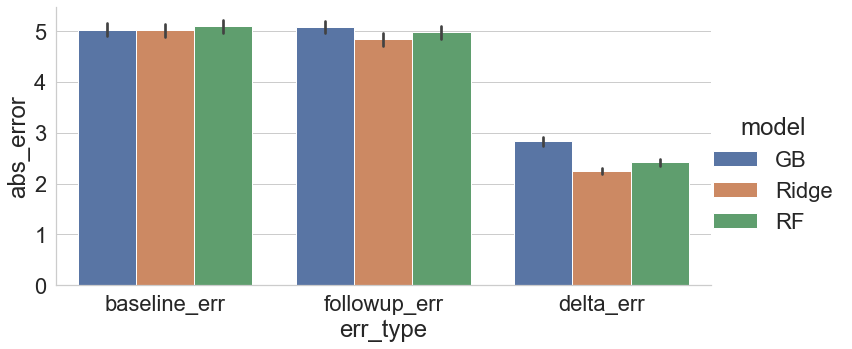

In [6]:
plot_df = perf_df_melt.copy()
plot_df["abs_error"] = np.abs(plot_df["error"]) 
print(plot_df.groupby(["chronoage_delta","err_type"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", hue="model", kind="bar", data=plot_df,aspect=2)

## Save summary results

In [7]:
save_summary_results = False
if save_summary_results:
    perf_df_melt.to_csv(f"{summary_results_dir}baseline_model_single_visit_train_full_ses2_test_two_visit_subset.csv")

## Case2 results
- Train on train_metadata subset of ses2 data from subjects with two visits. 
- Test on ses2 and ses3 scans from test_metadata subjects. 

In [8]:
two_visit_subset_dir = f"{results_dir}two_visit_subset/"

# Session 2 predictions
#{"MAE": 5.160370131691216, "session": 2, "feature_kind": "thickness"}
ses2_subdir_GB = f"{two_visit_subset_dir}GB/freesurfer_age_prediction_2021-11-10T15:34:26.163051" 

# {"MAE": 4.924392343314655, "feature_kind": "thickness", "train_session": 2, "test_session": 2, "model": "ridge"}
ses2_subdir_ridge = f"{two_visit_subset_dir}ridge/freesurfer_age_prediction_2021-12-02T16:05:11.443485"

# {"MAE": 5.188425120772947, "feature_kind": "thickness", "train_session": 2, "test_session": 2, "model": "RF"}
ses2_subdir_RF = f"{two_visit_subset_dir}RF/freesurfer_age_prediction_2021-12-02T15:19:33.307858"


## Session 3 predictions
#{"MAE": 5.401824082667036, "feature_kind": "thickness", "train_session": 2, "test_session": 3}
ses3_subdir_GB = f"{two_visit_subset_dir}GB/freesurfer_age_prediction_2021-11-10T16:00:20.678190" 
ses3_subdir_RF = f"{two_visit_subset_dir}RF/freesurfer_age_prediction_2021-12-02T16:37:28.135012"
ses3_subdir_ridge = f"{two_visit_subset_dir}ridge/freesurfer_age_prediction_2021-12-02T16:37:28.134989"

model_perf_dict =   {
                    "GB": (ses2_subdir_GB, ses3_subdir_GB),
                    "Ridge": (ses2_subdir_ridge, ses3_subdir_ridge),
                    "RF": (ses2_subdir_RF, ses3_subdir_RF)
                    }


In [9]:
perf_df_concat = pd.DataFrame()
for model_name, perf_dirs in model_perf_dict.items():
    ses2_subdir = perf_dirs[0]
    ses3_subdir = perf_dirs[1]

    ses2_y_true_df = pd.read_csv(f"{ses2_subdir}/y_true.csv")
    ses3_y_true_df = pd.read_csv(f"{ses3_subdir}/y_true.csv")
    ses2_y_true_df = ses2_y_true_df.rename(columns={"Unnamed: 0":"eid"})
    ses3_y_true_df = ses3_y_true_df.rename(columns={"Unnamed: 0":"eid"})

    ses2_preds_df = pd.read_csv(f"{ses2_subdir}/predictions.csv")
    ses3_preds_df = pd.read_csv(f"{ses3_subdir}/predictions.csv")
    ses2_preds_df = ses2_preds_df.rename(columns={"0":"brainage_at_ses2"})
    ses3_preds_df = ses3_preds_df.rename(columns={"0":"brainage_at_ses3"})

    ses2_df = pd.merge(ses2_y_true_df,ses2_preds_df, on="eid")
    ses3_df = pd.merge(ses3_y_true_df,ses3_preds_df, on="eid")

    perf_df = pd.merge(ses2_df,ses3_df,on="eid")
    perf_df["model"] = model_name

    perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
    perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]

    perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
    perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]
    perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]

    perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

    n_BBs = perf_df["Benjamin_Button"].sum()
    print(f"model:{model_name}, n BBs: {n_BBs} ({100*n_BBs/len(perf_df):4.3f}%)")

    perf_df_concat = perf_df_concat.append(perf_df)
    
perf_df_melt = perf_df_concat.melt(id_vars=["eid", "model", "age_at_ses2",	"brainage_at_ses2",	
                                    "age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
            value_vars=['baseline_err', 'followup_err', 'delta_err'],
            var_name='err_type', value_name='error')

model:GB, n BBs: 443 (41.911%)
model:Ridge, n BBs: 377 (39.353%)
model:RF, n BBs: 386 (40.292%)


## Plots

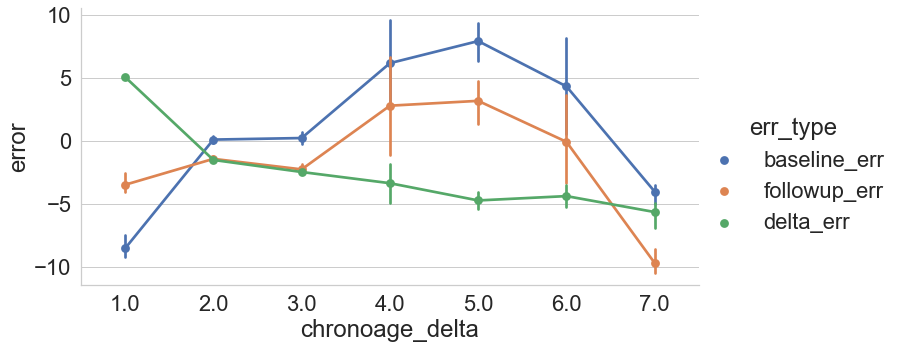

In [10]:
plot_df = perf_df_melt.copy()
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="chronoage_delta",y="error", hue="err_type", kind="point", data=plot_df,aspect=2)

chronoage_delta  err_type    
1.0              baseline_err    8.562594
                 delta_err       5.057786
                 followup_err    3.504808
2.0              baseline_err    5.133064
                 delta_err       2.214016
                 followup_err    5.278914
3.0              baseline_err    4.739606
                 delta_err       2.884426
                 followup_err    5.123902
4.0              baseline_err    6.408468
                 delta_err       3.520402
                 followup_err    6.112829
5.0              baseline_err    8.495545
                 delta_err       4.749688
                 followup_err    5.162818
6.0              baseline_err    8.018956
                 delta_err       4.405061
                 followup_err    6.626194
7.0              baseline_err    4.055300
                 delta_err       5.673504
                 followup_err    9.728804
Name: abs_error, dtype: float64


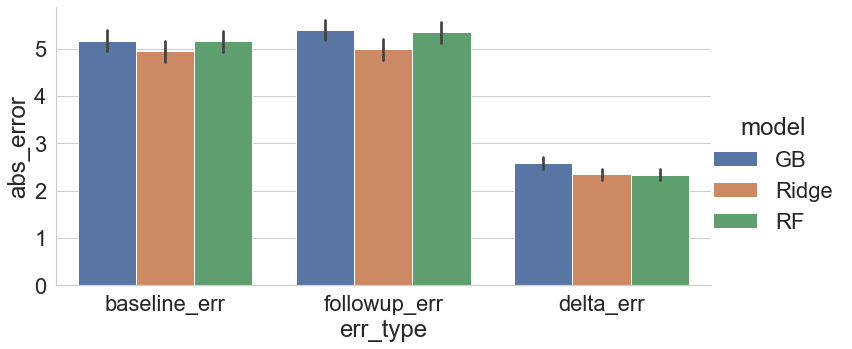

In [11]:
plot_df = perf_df_melt.copy()
plot_df["abs_error"] = np.abs(plot_df["error"]) 
print(plot_df.groupby(["chronoage_delta","err_type"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", hue="model", kind="bar", data=plot_df,aspect=2)

In [12]:
save_summary_results = False
if save_summary_results:
    perf_df_melt.to_csv(f"{summary_results_dir}baseline_model_single_visit_train_two_visit_subset_test_two_visit_subset.csv")